In [1]:
from D2Receptor import D2Receptor
from utils import ExponentialSynapse, SynapticNeuron, InputCurrent
from neuron import h
from neuron.units import ms, mV
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
h.load_file("stdrun.hoc")

1.0

In [3]:
N_glutamate_neurons = 10
neurons = []
radius = 50

for i in tqdm(range(N_glutamate_neurons)):
    theta = i * 2 * h.PI / N_glutamate_neurons
    neurons.append(SynapticNeuron(neuron_type="glutamate_neuron", gid=i, create_dendrite=False, 
                        hodgkin_huxley=True, x=h.cos(theta) * radius, y=h.sin(theta) + radius, z=0, theta=theta, 
                        n_soma_segments=1, n_dendrite_segments=0))

100%|██████████| 10/10 [00:00<00:00, 11919.02it/s]


In [3]:
h.nrn_load_dll("./NMODL/arm64/.libs/libnrnmech.so")

1.0

In [5]:
mt = h.MechanismType(0)
mname  = h.ref('')
for i in range(mt.count()):
    mt.select(i)
    mt.selected(mname)
    print(f"Mechanism: {mname[0]}")

# Print the names of all point processes
mt = h.MechanismType(1)
mname  = h.ref('')
for i in range(mt.count()):
    mt.select(i)
    mt.selected(mname)
    print(mname[0])

Mechanism: morphology
Mechanism: capacitance
Mechanism: pas
Mechanism: extracellular
Mechanism: fastpas
Mechanism: na_ion
Mechanism: k_ion
Mechanism: hh
Mechanism: cl_ion
IClamp
AlphaSynapse
ExpSyn
Exp2Syn
SEClamp
VClamp
OClamp
APCount
NetStim
IntFire1
IntFire2
IntFire4
PointProcessMark
PatternStim
GABA_A_Channel
GenericLigand
GenericReceptor
NMDA16_2
NMDA_Channel_Calcium
SynNoise


In [4]:
total_sim_time = 600 # ms
resting_membrane_potential = -65
dt = 0.25

In [7]:
# TODO:
# 1. create netstim current source 
# 2. create double exponential synapse 
    # set reversal potential to -80
# 3. create presynaptic neuron with HH dynamics (glutamate emitter neuron)
# 4. connect presynaptic neuron voltage to double exponential synapse 
# 5. create second netsim current source 
# 6. create single exponential synapse 
    # set reversal potential 50.0
# 7. connect presynaptic neuron voltage to single exponential synapse 
# 8. create postsynaptic neuron with HH dynamics 
# 9. create single exponential synapse 
    # set reversal potential to -80
# 10. connect postsynaptic neuron voltage to single exponential synapse 
# 11. TBD: create third netstim source 
# 12. TBD: create single exponential synapse 

# TODO:
### Connect postsynpatic soma to dendrites 
### Add passive property to dendrites 
### Keep HH dynamics in postsynaptic neuron

### 1. Add glutamatergic properties to presynaptic neuron 
### 2. NMDA receptor for glutamate (in striatum)
### 3. Create dopamine using GenericLigand? Or find separate model on ModelDB 
### 4. Create D2 Receptor - revisit concentration equations in implementation 
        ### Write .mod file with D2 Receptor properties 


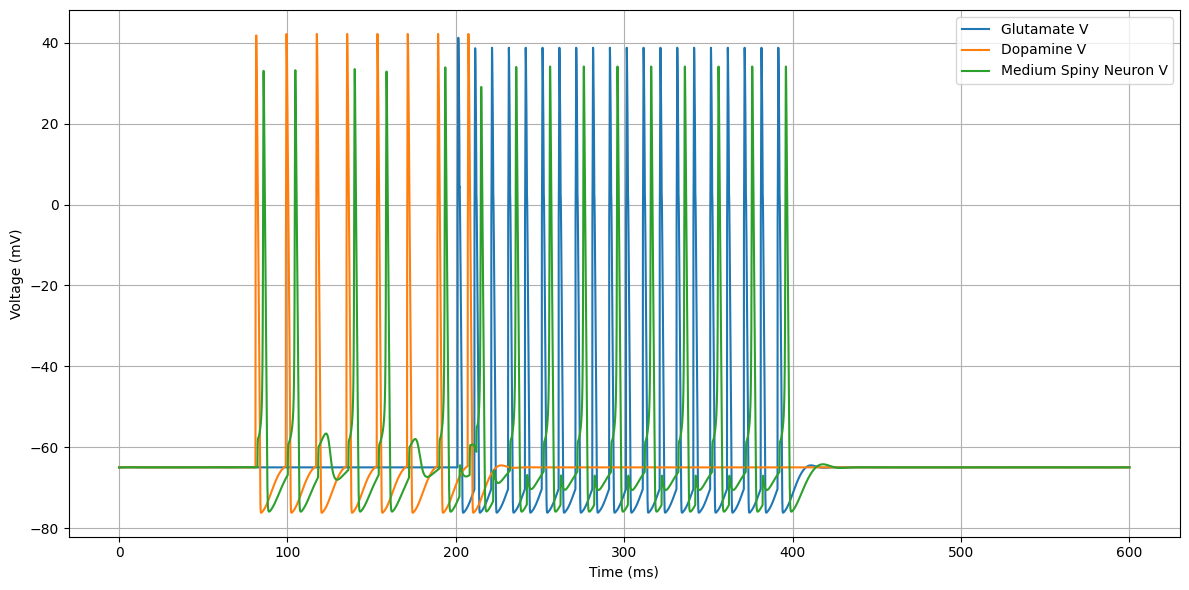

In [5]:
# what is the point of using a glutamate and dopamine neuron as input to a gabaergic interneuron in the striatum?
## projections sent from these two neurons to Gaba in the striatum leads to 
## fewer action potential release from the striatum to the globus pallidus externus in the indirect pathway of the basal ganglia 

## the effects of dopamine from the Substantia Nigra to the Striatum are neuromodulatory and shouldn't be measured by excitatory, inhibitory connections 
## instead the concentration of dopamine should be measured 

# initial current to glutamate neuron 
glutamate_current = InputCurrent(first_spike_time=200.0, average_time_between_spikes=10.0)

# glutamate neuron 
glutamate_soma = h.Section("glutamate_soma")
glutamate_soma.insert("hh")
glutamate_neuron = h.GenericLigand(glutamate_soma(0.5))
glutamate_neuron.C_init = 0.8

# synapse to connect current to glutamate
glutamate_syn = h.ExpSyn(glutamate_soma(0.5))
glutamate_syn.e = 0.0

# connect glutamate voltage to synapse 
glutamate_netcon = h.NetCon(glutamate_soma(0.5)._ref_v, glutamate_syn, sec=glutamate_soma)
glutamate_netcon.threshold = 0.0 
glutamate_netcon.weight[0] = 150.0
glutamate_netcon.delay = 1 
# connect current to glutamate
glutamate_current_netcon = h.NetCon(glutamate_current.input_current, glutamate_syn)
glutamate_current_netcon.threshold = 0.0 
glutamate_current_netcon.weight[0] = 100.0

dopamine_current = InputCurrent(first_spike_time=80.0, average_number_spikes=8.0, average_time_between_spikes=18.0)
# dopamine neuron
dopamine_soma = h.Section("dopamine_soma")
dopamine_soma.insert("hh")
# TODO: add mod file for d2 receptor. model dopamine concentration with more dynamics
dopamine_neuron = h.GenericLigand(dopamine_soma(0.5))
dopamine_neuron.C_init = 0.7

# inject current to dopamine 
dopamine_excitatory_syn = h.ExpSyn(dopamine_soma(0.5))
dopamine_excitatory_syn.e = 0.0
dopamine_current_netcon = h.NetCon(dopamine_current.input_current, dopamine_excitatory_syn)
dopamine_current_netcon.threshold = 0.0 
dopamine_current_netcon.weight[0] = 50.0

# medium spiny neuron in dorsal striatum with gabaergic properties
# have multiple receptors -> 1. glutamate (AMPA/NMDA) 2. dopamine (D2) 3. gaba (GABA-A/GABA-B)
msn_soma = h.Section("msn_soma")
msn_soma.insert("hh")
msn_dendrites = h.Section("msn_dendrites")
msn_dendrites.connect(msn_soma(0.5))
# medium spiny neuron in dorsal striatum that receives glutamate input from the cerebral cortex and dopamine from the SNc
msn_neuron = h.GenericLigand(msn_soma(0.5))

# msn receptor 
msn_receptor = h.GenericReceptor(msn_soma(1))
msn_receptor.n_ligands = 2 
msn_receptor.capacity = 1.0

# msn synapse 
msn_syn = h.ExpSyn(msn_soma(1))
msn_syn.e = 0.0 

# connect glutamate voltage to msn synapse
glutamate_msn_soma_netcon = h.NetCon(glutamate_soma(0.5)._ref_v, msn_syn, sec=glutamate_soma)
glutamate_msn_soma_netcon.threshold = 0.0 
glutamate_msn_soma_netcon.weight[0] = 4.0 
glutamate_msn_soma_netcon.delay = 1 

# connect dopamine voltage to msn synapse
dopamine_msn_soma_netcon = h.NetCon(dopamine_soma(0.5)._ref_v, msn_syn, sec=dopamine_soma)
dopamine_msn_soma_netcon.threshold = 0.0 
dopamine_msn_soma_netcon.weight[0] = 4.0 
dopamine_msn_soma_netcon.delay = 1 

# set the ligand concentration to each unoccupied ligand binding site of the MSN receptor 
h.setpointer(glutamate_neuron._ref_C, 'C_lig1', msn_receptor)
h.setpointer(dopamine_neuron._ref_C, 'C_lig2', msn_receptor)

# connect glutamate voltage to msn concentration  
glutamate_msn_netcon = h.NetCon(glutamate_soma(0.5)._ref_v, msn_neuron, sec=glutamate_soma)
glutamate_msn_netcon.threshold = 0.0 
glutamate_msn_netcon.weight[0] = 150.0 
glutamate_msn_netcon.delay = 1 

t_vec = h.Vector().record(h._ref_t)
v_glutamate = h.Vector().record(glutamate_soma(0.5)._ref_v)
v_dopamine = h.Vector().record(dopamine_soma(0.5)._ref_v)
v_msn = h.Vector().record(msn_soma(1)._ref_v)
glutamate_conc = h.Vector().record(glutamate_neuron._ref_C)
dopamine_conc = h.Vector().record(dopamine_neuron._ref_C)
msn_conc = h.Vector().record(msn_neuron._ref_C)

h.finitialize(-65)
h.continuerun(total_sim_time)

plt.figure(figsize=(12, 6))
plt.plot(t_vec, v_glutamate, label='Glutamate V')
plt.plot(t_vec, v_dopamine, label='Dopamine V')
plt.plot(t_vec, v_msn, label='Medium Spiny Neuron V')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

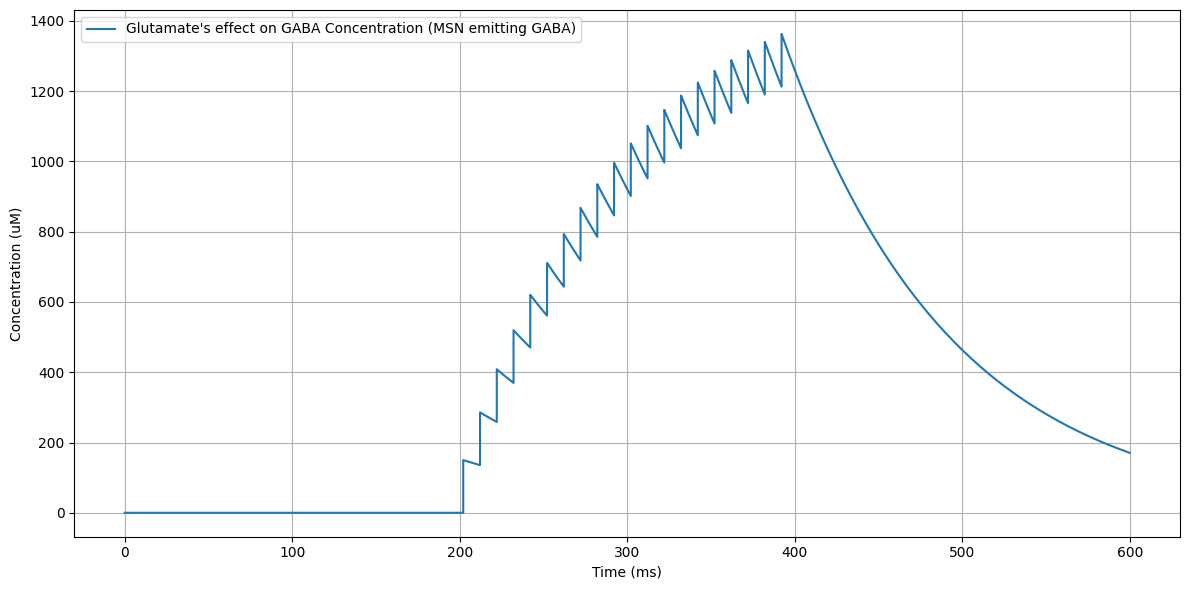

In [7]:
plt.figure(figsize=(12, 6))
# plt.plot(t_vec, glutamate_conc, label='Glutamate Concentration')
# plt.plot(t_vec, dopamine_conc, label='Dopamine Concentration')
plt.plot(t_vec, msn_conc, label="Glutamate's effect on GABA Concentration (MSN emitting GABA)")
plt.xlabel('Time (ms)')
plt.ylabel('Concentration (uM)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
'''
# presynaptic neuron with HH dynamics 
presynaptic_neuron = h.Section("pre_soma")
presynaptic_neuron.insert("hh")

# should have two input stimuli: glutamate from cortex to gaba and dopamine from substantia nigra to gaba
# TODO: dont use D2 dopamine concentration dynamics yet. model dopamine using GenericLigand

# postsynaptic soma with HH dynamics 
postsynaptic_soma = h.Section("post_soma") 
postsynaptic_soma.insert("hh") 

postsynaptic_dendrites = h.Section("post_dendrites")
postsynaptic_dendrites.insert("pas")
postsynaptic_dendrites.connect(postsynaptic_soma(0.5))

# synapse to connect initial current source to neuron 
presynaptic_double_exp_syn = h.Exp2Syn(presynaptic_neuron(0.5))
inhibitory_erev = -80.0
presynaptic_double_exp_syn.e = inhibitory_erev
presynaptic_double_exp_syn.tau1 = 0.1 # rise time
presynaptic_double_exp_syn.tau2 = 10.0 # decay

# d2 autoreceptor approx: connect the presynaptic neurons voltage to its own synapse 
pre_neuron_double_exp_netcon = h.NetCon(presynaptic_neuron(0.5)._ref_v, presynaptic_double_exp_syn)
pre_neuron_double_exp_netcon.threshold = 0.0
pre_neuron_double_exp_netcon.weight[0] = 100.0
pre_neuron_double_exp_netcon.delay = 1 

# second current source to presynaptic neuron 
second_pre_current = InputCurrent(first_spike_time=5.0, average_time_between_spikes=7.0)

# single exponential synapse to connect second current source to presynaptic neuron 
presynaptic_single_exp_syn = h.ExpSyn(presynaptic_neuron(0.5))
excitatory_erev = 0.0
presynaptic_single_exp_syn.e = excitatory_erev 

# connect pre neuron voltage to single exp synapse 
pre_neuron_single_exp_netcon = h.NetCon(second_pre_current.input_current, presynaptic_single_exp_syn)
pre_neuron_single_exp_netcon.threshold = 0.0 
pre_neuron_single_exp_netcon.weight[0] = 10.0
pre_neuron_single_exp_netcon.delay = 1 
'''

'\n# presynaptic neuron with HH dynamics \npresynaptic_neuron = h.Section("pre_soma")\npresynaptic_neuron.insert("hh")\n\n# should have two input stimuli: glutamate from cortex to gaba and dopamine from substantia nigra to gaba\n# TODO: dont use D2 dopamine concentration dynamics yet. model dopamine using GenericLigand\n\n# postsynaptic soma with HH dynamics \npostsynaptic_soma = h.Section("post_soma") \npostsynaptic_soma.insert("hh") \n\npostsynaptic_dendrites = h.Section("post_dendrites")\npostsynaptic_dendrites.insert("pas")\npostsynaptic_dendrites.connect(postsynaptic_soma(0.5))\n\n# synapse to connect initial current source to neuron \npresynaptic_double_exp_syn = h.Exp2Syn(presynaptic_neuron(0.5))\ninhibitory_erev = -80.0\npresynaptic_double_exp_syn.e = inhibitory_erev\npresynaptic_double_exp_syn.tau1 = 0.1 # rise time\npresynaptic_double_exp_syn.tau2 = 10.0 # decay\n\n# d2 autoreceptor approx: connect the presynaptic neurons voltage to its own synapse \npre_neuron_double_exp_net

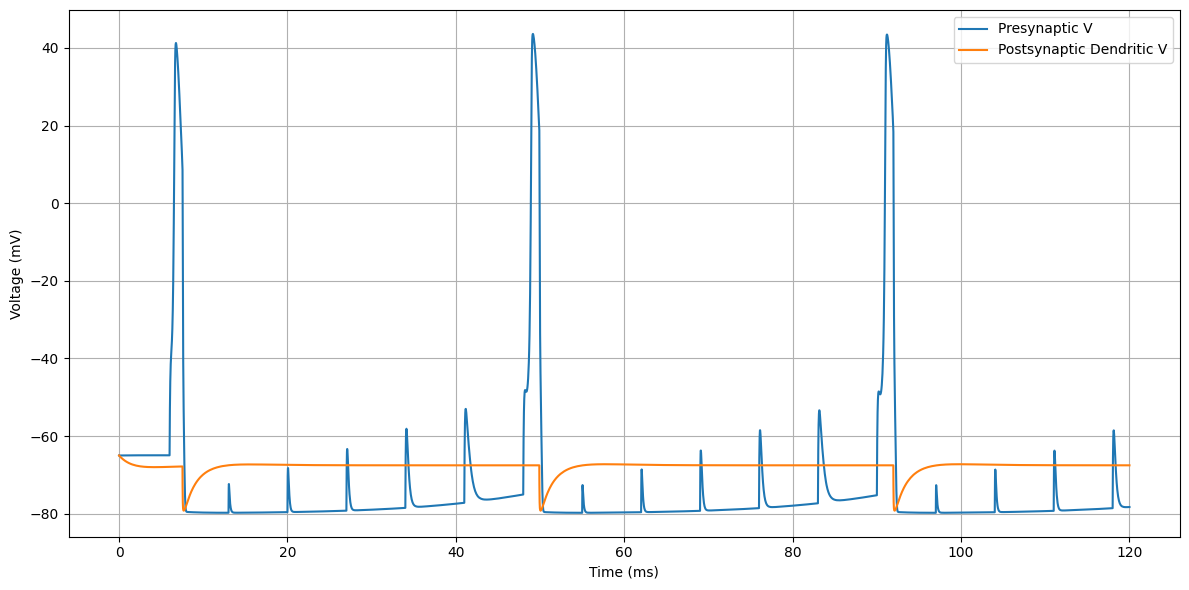

In [9]:
# single exponential synapse for postsynaptic neuron with inhibitory properties
postsynaptic_single_exp_syn_inhibitory = h.ExpSyn(postsynaptic_soma(1))
postsynaptic_single_exp_syn_inhibitory.e = inhibitory_erev

# single exponential synapse for postsynaptic neuron with excitatory properties 
postsynaptic_single_exp_syn_excitatory = h.ExpSyn(postsynaptic_soma(1))
postsynaptic_single_exp_syn_excitatory.e = excitatory_erev 
postsynaptic_single_exp_syn_excitatory.tau = 0.01

# third current source to postsynaptic neuron 
third_post_current = InputCurrent(first_spike_time=10.0)

# connect third battery source to postsynaptic synapse 
post_neuron_single_exp_syn_netcon_battery = h.NetCon(third_post_current.input_current, postsynaptic_single_exp_syn_excitatory)
post_neuron_single_exp_syn_netcon_battery.weight[0] = 0.0
post_neuron_single_exp_syn_netcon_battery.delay = 1
post_neuron_single_exp_syn_netcon_battery.threshold = 0.0 

# connect presynaptic neuron voltage to postsynaptic synapse 
post_neuron_single_exp_syn_netcon = h.NetCon(presynaptic_neuron(0.5)._ref_v, postsynaptic_single_exp_syn_inhibitory)
post_neuron_single_exp_syn_netcon.weight[0] = 150.0
post_neuron_single_exp_syn_netcon.delay = 1
post_neuron_single_exp_syn_netcon.threshold = 0.0

t_vec = h.Vector().record(h._ref_t)
v_pre = h.Vector().record(presynaptic_neuron(0.5)._ref_v)
v_post = h.Vector().record(postsynaptic_soma(1)._ref_v)

h.finitialize(-65)
h.continuerun(120)

plt.figure(figsize=(12, 6))
plt.plot(t_vec, v_pre, label='Presynaptic V')
plt.plot(t_vec, v_post, label='Postsynaptic Dendritic V')
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# glutamate from motor cortex
presynaptic_neuron = neurons[0]
glutamate = h.GenericLigand(presynaptic_neuron.soma(0.5))
glutamate.decay_rate = 0.1
syn = ExponentialSynapse(presynaptic_neuron, soma_synapse=True)
syn.synapse.e = 0.0

postsynaptic_neuron = SynapticNeuron(neuron_type="striatal_neuron", gid=11, create_dendrite=True, 
                        hodgkin_huxley=True, x=h.cos(theta) * radius, y=h.sin(theta) + radius, z=0, theta=theta, 
                        n_soma_segments=1, n_dendrite_segments=1)
# postsynaptic_neuron.soma.insert('pas')
# striatal GABAergic neuron for dopamine to bind onto
presynaptic_neuron_2 = SynapticNeuron(neuron_type="gaba_neuron", gid=12, create_dendrite=True, 
                        hodgkin_huxley=True, x=h.cos(theta) * radius, y=h.sin(theta) + radius, z=0, theta=theta, 
                        n_soma_segments=1, n_dendrite_segments=1)
# Attach GABA emitter to post neuron
gaba = h.GABA_A_Channel(postsynaptic_neuron.soma(0.5))
gaba.ecl = -80.0
# Attach GABA A receptor to post neuron
gaba_a_receptor = h.GenericReceptor(postsynaptic_neuron.soma(0.5))
gaba_a_receptor.capacity = 1.0 
gaba_a_receptor.n_ligands = 1
# syn_2 = ExponentialSynapse(presynaptic_neuron_2, soma_synapse=True)
# syn_2.synapse.e = 0.0
# Stand in Dopamine NT and synapse
fake_dopamine_neuron = SynapticNeuron(neuron_type="dopamine_nt", gid=12, create_dendrite=True, hodgkin_huxley=False, 
                                    x=h.cos(theta) * radius, y=h.sin(theta) + radius, z=0, theta=theta, 
                                    n_soma_segments=1, n_dendrite_segments=1)
fake_dopamine_neuron.soma.insert('pas')
dopamine_ligand = h.GenericLigand(fake_dopamine_neuron.soma(0.5))
dopamine_ligand.decay_rate = 0.05  
dopamine_ligand.C = 1.0

dopamine_synapse = ExponentialSynapse(fake_dopamine_neuron, soma_synapse=False)
d2_receptor = D2Receptor(dopamine_ligand=None, exponential_synapse=dopamine_synapse, resting_membrane_potential=-65.0, G_protein_threshold=10.0)
# insert synaptic noise 
pre_noise = h.SynNoise(0.5, sec=presynaptic_neuron.soma)
pre_noise.f0 = 0
pre_noise.f1 = 0.3
pre_noise_2 = h.SynNoise(0.5, sec=presynaptic_neuron_2.soma)
pre_noise_2.f0 = 0
pre_noise_2.f1 = 0.3
post_noise = h.SynNoise(0.5, sec=postsynaptic_neuron.soma)
post_noise.f0 = 0
post_noise.f1 = 0.3
dop_noise = h.SynNoise(0.5, sec=fake_dopamine_neuron.soma)
dop_noise.f0 = 0
dop_noise.f1 = 0.3

nmda_receptor = h.GenericReceptor(postsynaptic_neuron.soma(0.5))
nmda_receptor.capacity = 1.0
nmda_receptor.n_ligands = 2

nmda = h.NMDA_Channel_Calcium(postsynaptic_neuron.soma(0.5))
nmda.gmax = 0.01
nmda.e = 0
nmda.mg = 1
nmda.taur = 80

# set ligands to bind to receptor
h.setpointer(glutamate._ref_C, "C_lig1", nmda_receptor)
# set the activation of NMDA to the activation of the NMDA receptor
h.setpointer(nmda_receptor._ref_activation, "receptor_activation", nmda)
# set activation of GABA to activation of GABA receptor 
h.setpointer(gaba_a_receptor._ref_activation, "receptor_activation", gaba)

2025-05-11 15:03:28,598 Initialized D2 Receptor.


printing wholetree
SynapticNeuron[11].striatal_neuron
SynapticNeuron[11].dendrites
printing wholetree
SynapticNeuron[12].gaba_neuron
SynapticNeuron[12].dendrites
printing wholetree
SynapticNeuron[12].dopamine_nt
SynapticNeuron[12].dendrites


In [ ]:
nc_glutamate = h.NetCon(presynaptic_neuron.soma(0.5)._ref_v, ) # presynaptic source on the left hand side (battery or source of voltage) that drives dopamine release
# use double exp synapse on the receiving side (attached to a neuron that has HH dynamics) would have a negative reversal potential (pick different rev potentials)
nc_glutamate.threshold = -20
nc_glutamate.weight[0] = 0.8
nc_glutamate.delay = 1

# dopamine would indirectly modulate gaba receptor 
# dopamine sysnapse is a double exp synapse 
# post synaptic neuron attaches to GABA A Receptor (single exponential synapse)

input_current1 = InputCurrent(average_number_spikes=3, 
                            first_spike_time=100.0, average_time_between_spikes=50.0)
input_current2 = InputCurrent(average_number_spikes=3, 
                            first_spike_time=400.0, average_time_between_spikes=10.0)
input_current3 = InputCurrent(average_number_spikes=10, 
                            first_spike_time=1000.0, average_time_between_spikes=30.0)
input_current4 = InputCurrent(average_number_spikes=5, 
                            first_spike_time=800.0, average_time_between_spikes=80.0)
input_current5 = InputCurrent(average_number_spikes=15, 
                            first_spike_time=1200.0, average_time_between_spikes=20.0)
input_current6 = InputCurrent(average_number_spikes=10, 
                            first_spike_time=50.0, average_time_between_spikes=200.0)

NEURON: NetCon not enough arguments
 near line 0
 ^
        NetCon(...)


RuntimeError: hocobj_call error

In [ ]:
print(input_current3.input_current.number)

10.0


In [ ]:
nc = h.NetCon(presynaptic_neuron.soma(0.5)._ref_v, glutamate)
nc.threshold = -20
nc.weight[0] = 0.8
nc.delay = 1

nc1 = h.NetCon(input_current1.input_current, syn.synapse, sec=presynaptic_neuron.soma)
nc1.threshold = -20
nc1.weight[0] = 0.5
nc1.delay = 1

nc2 = h.NetCon(input_current2.input_current, syn.synapse, sec=presynaptic_neuron.soma)
nc2.threshold = -40
nc2.weight[0] = 0.1
nc2.delay = 1

nc3 = h.NetCon(input_current3.input_current, dopamine_synapse.synapse, sec=fake_dopamine_neuron.soma)
nc3.threshold = -10
nc3.weight[0] = 0.25
nc3.delay = 1

nc4 = h.NetCon(input_current4.input_current, dopamine_synapse.synapse, sec=fake_dopamine_neuron.soma)
nc4.threshold = -5
nc4.weight[0] = 0.15
nc4.delay = 1
'''
nc5 = h.NetCon(input_current5.input_current, syn_2.synapse, sec=presynaptic_neuron_2.soma)
nc5.threshold = -10
nc5.weight[0] = 0.25
nc5.delay = 1

nc6 = h.NetCon(input_current6.input_current, syn_2.synapse, sec=presynaptic_neuron_2.soma)
nc6.threshold = -5
nc6.weight[0] = 0.15
nc6.delay = 1
'''

'\nnc5 = h.NetCon(input_current5.input_current, syn_2.synapse, sec=presynaptic_neuron_2.soma)\nnc5.threshold = -10\nnc5.weight[0] = 0.25\nnc5.delay = 1\n\nnc6 = h.NetCon(input_current6.input_current, syn_2.synapse, sec=presynaptic_neuron_2.soma)\nnc6.threshold = -5\nnc6.weight[0] = 0.15\nnc6.delay = 1\n'

In [ ]:
# record data
t = h.Vector().record(h._ref_t)
# presynaptic voltage 1 
v_pre_1 = h.Vector().record(presynaptic_neuron.soma(0.5)._ref_v)
# presynaptic voltage 2
# v_pre_2 = h.Vector().record(presynaptic_neuron_2.soma(0.5)._ref_v)
# postsynaptic voltage 
v_post = h.Vector().record(postsynaptic_neuron.dendrites(0.5)._ref_v)
# dopamine neuron voltage 
v_dop = h.Vector().record(fake_dopamine_neuron.soma(0.5)._ref_v)
# record glutamate concentration from motor cortex
glutamate_conc = h.Vector().record(glutamate._ref_C)
nmda_act = h.Vector().record(nmda_receptor._ref_activation)
nmda_current = h.Vector().record(nmda._ref_i)
# na_current = h.Vector().record(postsynaptic_neuron.dendrites(0.5)._ref_ina)
ca_conc = h.Vector().record(nmda._ref_local_cai)  
da_conc = h.Vector().record(dopamine_ligand._ref_C)

In [ ]:
h.tstop = total_sim_time
h.v_init = resting_membrane_potential
h.dt = dt 

In [ ]:
for T in tqdm(range(total_sim_time)): 
    d2_receptor.step(weight=0.1, dt=0.050, total_sim_time=total_sim_time, input_current=input_current3.input_current.number)

  0%|          | 0/800 [00:00<?, ?it/s]

2025-04-20 18:00:32,734 DA concentration: 0.5
2025-04-20 18:00:32,738 D2AR: 0.0
2025-04-20 18:00:32,740 G: 0.0
2025-04-20 18:00:32,744 DA concentration: 0.9997499999999999
2025-04-20 18:00:32,748 D2AR: 0.026150000000000003
2025-04-20 18:00:32,751 G: 0.020000000000000004
2025-04-20 18:00:32,753 DA concentration: 1.4992501249999999
2025-04-20 18:00:32,756 D2AR: 0.0625411441125
2025-04-20 18:00:32,756 G: 0.060790000000000004
2025-04-20 18:00:32,758 DA concentration: 1.9985004999375
2025-04-20 18:00:32,760 D2AR: 0.0865969285193321
2025-04-20 18:00:32,764 G: 0.12319160500000001
2025-04-20 18:00:32,765 DA concentration: 2.4975012496875313
2025-04-20 18:00:32,766 D2AR: 0.09324529115885599
2025-04-20 18:00:32,766 G: 0.20805928919750002
2025-04-20 18:00:32,767 DA concentration: 2.9962524990626873
2025-04-20 18:00:32,767 D2AR: 0.09414239585312628
2025-04-20 18:00:32,767 G: 0.3162817107529013
2025-04-20 18:00:32,768 DA concentration: 3.494754372813156
2025-04-20 18:00:32,768 D2AR: 0.0953193925418

In [ ]:
h.finitialize(h.v_init)

: 

In [ ]:
h.continuerun(h.tstop)

0.0

In [ ]:
d2AR_list, daEX_list, V_list, TDA_list, G_list = (
    d2_receptor.d2AR_list,
    d2_receptor.daEX_list,
    d2_receptor.V_list,
    d2_receptor.TDA_list,
    d2_receptor.G_list,
)

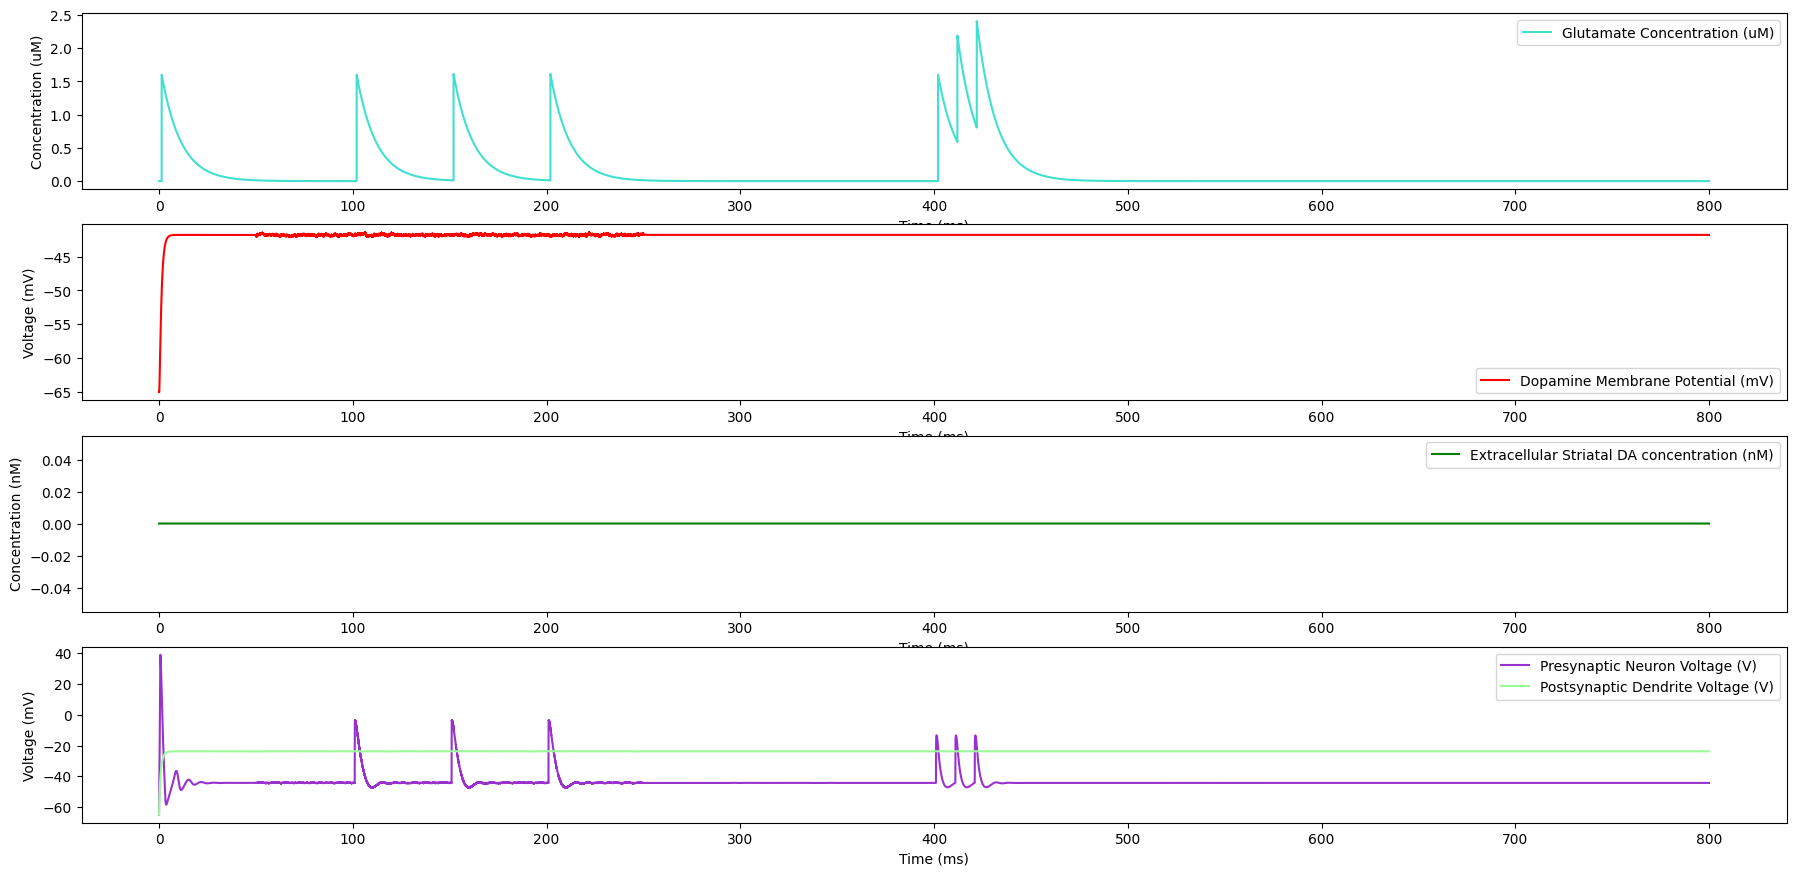

In [ ]:
plt.figure(figsize=(22, 16))

plt.subplot(6, 1, 1)
plt.plot(t, glutamate_conc, label="Glutamate Concentration (uM)", color = "turquoise")
plt.xlabel("Time (ms)")
plt.ylabel("Concentration (uM)")
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(t, v_dop, label="Dopamine Membrane Potential (mV)", color = "red")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(t, da_conc, label="Extracellular Striatal DA concentration (nM)", color = "green")
plt.xlabel("Time (ms)")
plt.ylabel("Concentration (nM)")
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(t, v_pre_1, label="Presynaptic Neuron Voltage (V)", color = "darkorchid")
plt.plot(t, v_post, label="Postsynaptic Dendrite Voltage (V)", color = "palegreen")
plt.xlabel("Time (ms)")
plt.ylabel("Voltage (mV)")
plt.legend()

plt.show()